# Imports & dataset loading

In [ ]:
from cancerclassification.data import *
from cancerclassification.nn import *
from cancerclassification.swav import *

from sklearn.metrics import accuracy_score
import torch.optim as optim

import seaborn as sns

%env CUDA_VISIBLE_DEVICES=0

In [ ]:
device = (
    "cuda:0" if torch.cuda.is_available() else "cpu"
)  # 0 indicates the GPU you gonna use
print(f"Using {device} device")

In [ ]:
dataset = read_data_MA_preprocessed()
idx = generate_indices(dataset)
cancer_dataset = CancerDatasetMA(dataset[:, 1:], dataset[:, 0], device)
dataloaders = get_dataloaders(cancer_dataset, idx, [256, 256, 256])
input_dim = dataloaders[0].dataset.inputs.shape[1] # 54675
output_dim = 1 # binary classification
w = compute_loss_pos_weights(dataset, device)

# Baseline

In [ ]:
name = "demo_baseline_microarray"
logger = LogResults(name, ["prop"])

steps = (
    list(np.arange(0.01, 0.05, 0.001))
    + list(np.arange(0.05, 0.14, 0.005))
    + list(np.arange(0.14, 0.30, 0.01))
    + list(np.arange(0.65, 1.05, 0.05))
)

for i in range(50):
    for prop in steps:
        logger.update_hyps([prop])
        
        # Finetuning and evaluation
        
        idx = generate_indices(dataset, prop=prop)
        base_bs = 256
        margin = 0.5
        bs = round(len(idx[0]) / (len(idx[0]) // base_bs + margin))
        dataloaders = get_dataloaders(cancer_dataset, idx, [bs, bs, bs])
        
        config_nn = {
            "epochs": 200,
            "lr_init": 0.0004,
            "early_stop": 5,
        }
        
        net = Net(input_dim, output_dim).to(device)
        train_nn(config_nn, dataloaders, net, weights=None, early_stop=config_nn["early_stop"], log=False, logger=logger, binary=True)
        logger.next_run()
        logger.show_progression()
            
    logger.save_csv()

<AxesSubplot:xlabel='prop', ylabel='test_acc'>

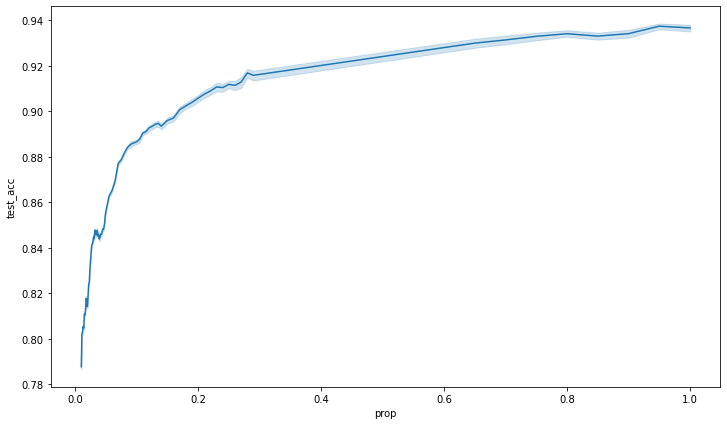

In [21]:
# df_results = logger.df_results
df_results = pd.read_csv("demo_baseline_microarray.csv")
df_le = (
    df_results.sort_values(by=["id", "epoch"], ascending=[False, False])
    .groupby("id", as_index=False)
    .first()
)
plt.figure(figsize=(12, 7))
sns.lineplot(data=df_le, x="prop", y="test_acc")

# Number of prototypes

In [ ]:
name = "demo_number_prototypes_microarray"
logger = LogResults(name, ["nprotos"])

nprotos = [2, 4, 6, 10, 16, 24, 32, 64]

for i in range(5):
    for nproto in nprotos:
        
        logger.update_hyps([nproto])
        
        config_swav = {
            "epochs": 200,
            "lr_init": 0.0001,
            "early_stop": 5,
            "coeff": 0.6,
        }
        
        # SwAV training
        
        idx = generate_indices(dataset)
        dataloaders = get_dataloaders(cancer_dataset, idx, [256, 256, 256])
        net_swav = NetSwav(input_dim, nproto=nproto).to(device)
        train_swav_tcga(config_swav, dataloaders, net_swav, device, config_swav["early_stop"])
        torch.save(net_swav.state_dict(), "data/s12/swav_state_dict_ma_0.pt")
        
        # Finetuning and evaluation
        
        idx = generate_indices(dataset, prop=0.03)
        base_bs = 256
        margin = 0.5
        bs = round(len(idx[0]) / (len(idx[0]) // base_bs + margin))
        dataloaders = get_dataloaders(cancer_dataset, idx, [bs, bs, bs])
        
        config_nn = {
            "epochs": 200,
            "lr_init": 0.001,
            "early_stop": 5,
        }
        
        for i in range(10):
            net = Net(input_dim, output_dim).to(device)
            transfer_weights(net, f"data/s12/swav_state_dict_ma_0.pt")
            train_nn(config_nn, dataloaders, net, weights=None, early_stop=config_nn["early_stop"], log=False, logger=logger, binary=True)
            logger.next_run()
            logger.show_progression()
            
        logger.save_csv()

<AxesSubplot:xlabel='nprotos', ylabel='test_acc'>

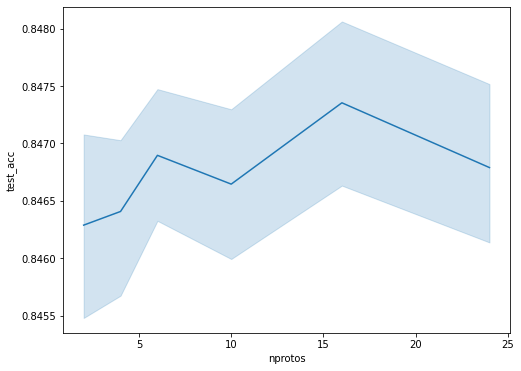

In [22]:
# df_results = logger.df_results
df_results = pd.read_csv("demo_number_prototypes_microarray.csv")
df_le = (
    df_results.sort_values(by=["id", "epoch"], ascending=[False, False])
    .groupby("id", as_index=False)
    .first()
)
df_le = df_le.loc[df_le["nprotos"] < 30]
plt.figure(figsize=(8, 6))
sns.lineplot(data=df_le, x="nprotos", y="test_acc")

# Epsilon value

In [ ]:
name = "demo_epsilon_value_microarray"
logger = LogResults(name, ["epsilon"])

epsilons = [0.05, 0.06, 0.07, 0.08, 0.09, 0.10, 0.11, 0.12, 0.13, 0.14]

for i in range(5):
    for eps in epsilons:
        
        logger.update_hyps([eps])
        
        config_swav = {
            "epochs": 200,
            "lr_init": 0.0001,
            "early_stop": 5,
            "coeff": 0.6,
        }
        
        # SwAV training
        
        idx = generate_indices(dataset)
        dataloaders = get_dataloaders(cancer_dataset, idx, [256, 256, 256])
        net_swav = NetSwav(input_dim, nproto=16).to(device)
        train_swav_tcga(config_swav, dataloaders, net_swav, device, config_swav["early_stop"], eps=eps)
        torch.save(net_swav.state_dict(), "data/s12/swav_state_dict_ma_0.pt")
        
        # Finetuning and evaluation
        
        idx = generate_indices(dataset, prop=0.03)
        base_bs = 256
        margin = 0.5
        bs = round(len(idx[0]) / (len(idx[0]) // base_bs + margin))
        dataloaders = get_dataloaders(cancer_dataset, idx, [bs, bs, bs])
        
        config_nn = {
            "epochs": 200,
            "lr_init": 0.001,
            "early_stop": 5,
        }
        
        for j in range(10):
            net = Net(input_dim, output_dim).to(device)
            transfer_weights(net, f"data/s12/swav_state_dict_ma_0.pt")
            train_nn(config_nn, dataloaders, net, weights=None, early_stop=config_nn["early_stop"], log=False, logger=logger, binary=True)
            logger.next_run()
            logger.show_progression()
            
        logger.save_csv()

<AxesSubplot:xlabel='epsilon', ylabel='test_acc'>

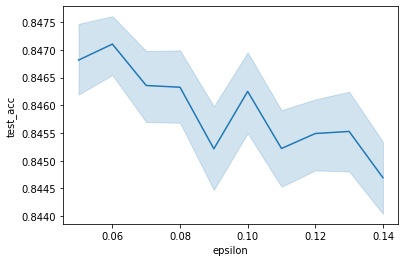

In [23]:
# df_results = logger.df_results
df_results = pd.read_csv("demo_epsilon_value_microarray.csv")
df_le = (
    df_results.sort_values(by=["id", "epoch"], ascending=[False, False])
    .groupby("id", as_index=False)
    .first()
)
# plt.figure(figsize=(10, 8))
sns.lineplot(data=df_le, x="epsilon", y="test_acc")

# Augmentation method

In [ ]:
name = "demo_augmentation_method_microarray"
logger = LogResults(name, ["coeff", "aug"])

coeffs = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
augmentations = ["noise", "mask"]

for i in range(5):
    for coeff in coeffs:
        for aug in augmentations:
            
            logger.update_hyps([coeff, aug])
            
            config_swav = {
                "epochs": 200,
                "lr_init": 0.0001,
                "early_stop": 5,
                "coeff": coeff,
            }
            
            # SwAV training
            
            idx = generate_indices(dataset)
            dataloaders = get_dataloaders(cancer_dataset, idx, [256, 256, 256])
            net_swav = NetSwav(input_dim, nproto=16).to(device)
            train_swav_tcga(config_swav, dataloaders, net_swav, device, config_swav["early_stop"], eps=0.05, method=aug)
            torch.save(net_swav.state_dict(), "data/s12/swav_state_dict_ma_0.pt")
        
            # Finetuning and evaluation

            idx = generate_indices(dataset, prop=0.03)
            base_bs = 256
            margin = 0.5
            bs = round(len(idx[0]) / (len(idx[0]) // base_bs + margin))
            dataloaders = get_dataloaders(cancer_dataset, idx, [bs, bs, bs])

            config_nn = {
                "epochs": 200,
                "lr_init": 0.001,
                "early_stop": 5,
            }

            for j in range(10):
                net = Net(input_dim, output_dim).to(device)
                transfer_weights(net, f"data/s12/swav_state_dict_ma_0.pt")
                train_nn(config_nn, dataloaders, net, weights=None, early_stop=config_nn["early_stop"], log=False, logger=logger, binary=True)
                logger.next_run()
                logger.show_progression()

            logger.save_csv()



<AxesSubplot:xlabel='coeff', ylabel='test_acc'>

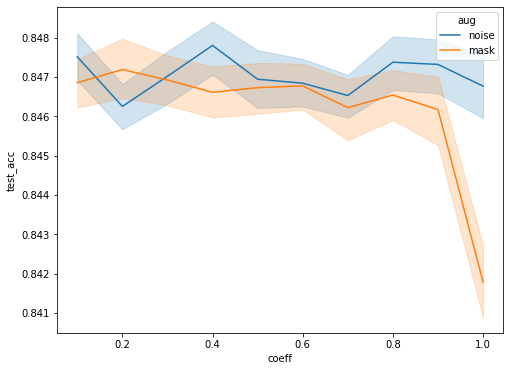

In [24]:
df_results = pd.read_csv("demo_augmentation_method_microarray.csv")
df_le = (
    df_results.sort_values(by=["id", "epoch"], ascending=[False, False])
    .groupby("id", as_index=False)
    .first()
)
plt.figure(figsize=(8, 6))
sns.lineplot(data=df_le, x="coeff", y
             ="test_acc", hue="aug")

# Batch size SwAV

In [ ]:
name = "demo_batch_size_swav_microarray_16"
logger = LogResults(name, ["bs"])

batch_sizes = [16, 32, 64, 128, 256]

for i in range(5):
    for bs in batch_sizes:
        
        logger.update_hyps([bs])
        
        config_swav = {
            "epochs": 200,
            "lr_init": 0.0001,
            "early_stop": 5,
            "coeff": 0.6,
        }
        
        # SwAV training
        
        idx = generate_indices(dataset)
        dataloaders = get_dataloaders(cancer_dataset, idx, [bs, 256, 256])
        net_swav = NetSwav(input_dim, nproto=16).to(device)
        train_swav_tcga(config_swav, dataloaders, net_swav, device, config_swav["early_stop"], eps=0.05)
        torch.save(net_swav.state_dict(), "data/s12/swav_state_dict_ma_0.pt")
        
        # Finetuning and evaluation
        
        idx = generate_indices(dataset, prop=0.03)
        base_bs = 256
        margin = 0.5
        bs = round(len(idx[0]) / (len(idx[0]) // base_bs + margin))
        dataloaders = get_dataloaders(cancer_dataset, idx, [bs, bs, bs])
        
        config_nn = {
            "epochs": 200,
            "lr_init": 0.001,
            "early_stop": 5,
        }
        
        for j in range(10):
            net = Net(input_dim, output_dim).to(device)
            transfer_weights(net, f"data/s12/swav_state_dict_ma_0.pt")
            train_nn(config_nn, dataloaders, net, weights=None, early_stop=config_nn["early_stop"], log=False, logger=logger, binary=True)
            logger.next_run()
            logger.show_progression()
            
        logger.save_csv()

<AxesSubplot:xlabel='bs', ylabel='test_acc'>

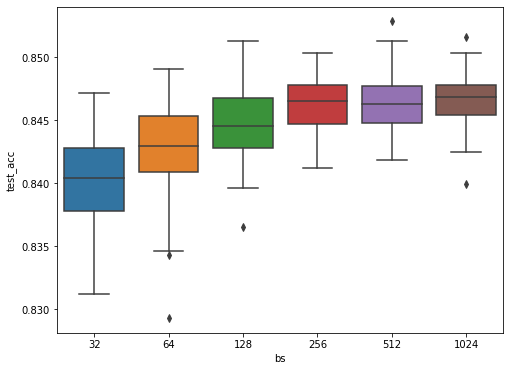

In [25]:
df_results = pd.read_csv("demo_batch_size_swav_microarray.csv")
df_le = (
    df_results.sort_values(by=["id", "epoch"], ascending=[False, False])
    .groupby("id", as_index=False)
    .first()
)
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_le, x="bs", y="test_acc")

# Epochs number SwAV

In [ ]:
name = "demo_nepochs_swav_microarray"
logger = LogResults(name, ["nepochs"])

maxepochs = [4, 8, 16, 32, 64, 128, 256]

for i in range(5):
    for nepochs in maxepochs:
        
        logger.update_hyps([nepochs])
        
        config_swav = {
            "epochs": nepochs,
            "lr_init": 0.0001,
            "early_stop": 0,
            "coeff": 0.6,
        }
        
        # SwAV training
        
        idx = generate_indices(dataset)
        dataloaders = get_dataloaders(cancer_dataset, idx, [256, 256, 256])
        net_swav = NetSwav(input_dim, nproto=60).to(device)
        train_swav_tcga(config_swav, dataloaders, net_swav, device, config_swav["early_stop"], eps=0.05)
        torch.save(net_swav.state_dict(), "data/s12/swav_state_dict_ma_0.pt")
        
        # Finetuning and evaluation
        
        idx = generate_indices(dataset, prop=0.03)
        base_bs = 256
        margin = 0.5
        bs = round(len(idx[0]) / (len(idx[0]) // base_bs + margin))
        dataloaders = get_dataloaders(cancer_dataset, idx, [bs, bs, bs])
        
        config_nn = {
            "epochs": 200,
            "lr_init": 0.001,
            "early_stop": 5,
        }
        
        for j in range(10):
            net = Net(input_dim, output_dim).to(device)
            transfer_weights(net, f"data/s12/swav_state_dict_ma_0.pt")
            train_nn(config_nn, dataloaders, net, weights=None, early_stop=config_nn["early_stop"], log=False, logger=logger, binary=True)
            logger.next_run()
            logger.show_progression()
            
        logger.save_csv()

<AxesSubplot:xlabel='nepochs', ylabel='test_acc'>

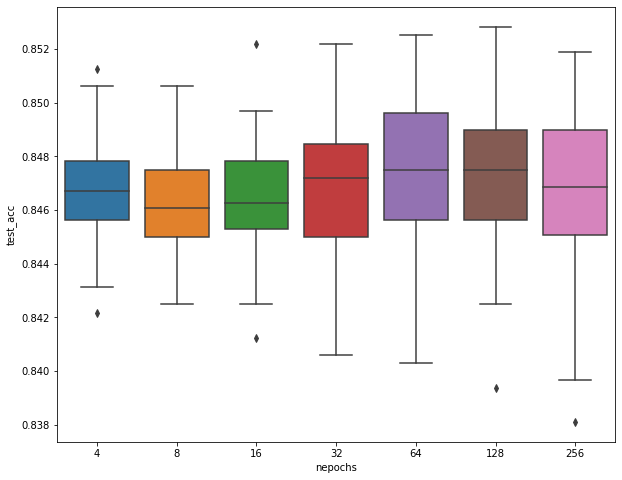

In [26]:
df_results = pd.read_csv("demo_nepochs_swav_microarray.csv")
df_le = (
    df_results.sort_values(by=["id", "epoch"], ascending=[False, False])
    .groupby("id", as_index=False)
    .first()
)
plt.figure(figsize=(10, 8))
sns.boxplot(data=df_le, x="nepochs", y="test_acc")

# SwAV pretraining

In [ ]:
for i in range(10):
        
    config_swav = {
        "epochs": 200,
        "lr_init": 0.0001,
        "early_stop": 5,
        "coeff": 0.6,
    }

    # SwAV training

    idx = generate_indices(dataset)
    dataloaders = get_dataloaders(cancer_dataset, idx, [256, 1403, 1403])
    net_swav = NetSwav(input_dim, nproto=16).to(device)
    train_swav_tcga(config_swav, dataloaders, net_swav, device, config_swav["early_stop"], eps=0.05)
    torch.save(net_swav.state_dict(), f"data/s15/swav_state_dict_bs_256_ma_{i}.pt")

# Learning rate fine-tuning

In [ ]:
name = "ma_lr"
logger = LogResults(name, ["pretraining", "lr_init"])
lrs = [0.002, 0.0015, 0.001, 0.0008, 0.0006, 0.0004, 0.0002, 0.0001, 0.00008, 0.00006, 0.00004, 0.00002]

for lr in lrs:
    for pretraining in  ["SwAV", "None"]:
        
        logger.update_hyps([pretraining, lr])
        
        # Finetuning and evaluation
        
        idx = generate_indices(dataset, prop=0.03)
        base_bs = 256
        margin = 0.5
        bs = round(len(idx[0]) / (len(idx[0]) // base_bs + margin))
        dataloaders = get_dataloaders(cancer_dataset, idx, [bs, bs, bs])

        config_nn = {
            "epochs": 200,
            "lr_init": lr,
            "early_stop": 5,
        }

        for i in range(20):

            net = Net(input_dim, output_dim).to(device)

            if pretraining == "SwAV":
                print("transfer...")
                transfer_weights(net, f"data/s15/swav_state_dict_bs_256_ma_{str(i % 10)}.pt")
            
            train_nn(config_nn, dataloaders, net, weights=None, early_stop=config_nn["early_stop"], log=False, logger=logger, binary=True)
            logger.next_run()
            logger.show_progression()

        logger.save_csv()
        

<AxesSubplot:xlabel='lr_init', ylabel='test_acc'>

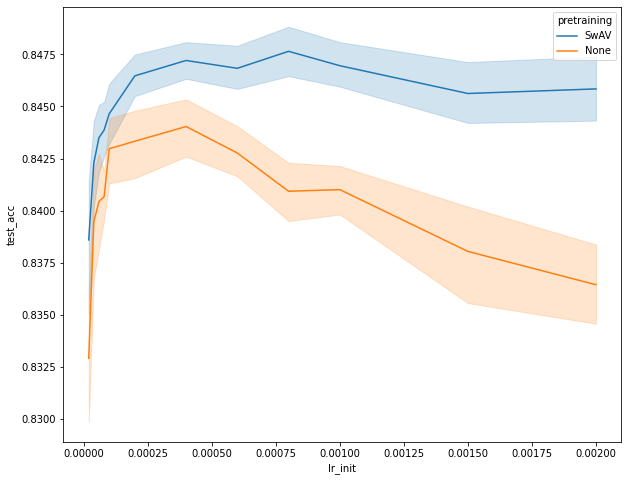

In [27]:
df_results = pd.read_csv("ma_lr.csv")
df_le = (
    df_results.sort_values(by=["id", "epoch"], ascending=[False, False])
    .groupby("id", as_index=False)
    .first()
)
plt.figure(figsize=(10, 8))
sns.lineplot(data=df_le, x="lr_init", y="test_acc", hue="pretraining")

# Final SwAV performance evaluation

In [ ]:
steps = (
    list(np.arange(0.01, 0.05, 0.001))
    + list(np.arange(0.05, 0.14, 0.005))
    + list(np.arange(0.14, 0.30, 0.01))
    + list(np.arange(0.30, 1.05, 0.05))
)

lr_catalog = {
    "SwAV": 0.0008,
    "None": 0.0004,
}

name = "demo_swav_performance_ma"
logger = LogResults(name, ["prop", "lr_init", "pretraining", "bs", "nb_labels"])

for prop in steps:
    
    # Finetuning and evaluation
    
    prop = round(prop, 3)
    idx = generate_indices(dataset, prop)
    base_bs = 256
    margin = 0.5
    bs = round(len(idx[0]) / (len(idx[0]) // base_bs + margin))

    dataloaders = get_dataloaders(cancer_dataset, idx, [bs, bs, bs])
    
    for pretraining in  ["SwAV", "None"]:
        
        lr = lr_catalog[pretraining]
        
        logger.update_hyps([prop, lr, pretraining, bs, len(idx[0])])

        config_nn = {
            "epochs": 200,
            "lr_init": lr,
            "early_stop": 5,
        }

        for i in range(50):

            net = Net(input_dim, output_dim).to(device)

            if pretraining == "SwAV":
                print("transfer...")
                transfer_weights(net, f"data/s15/swav_state_dict_bs_256_ma_{str(i % 10)}.pt")
            train_nn(config_nn, dataloaders, net, weights=w, early_stop=5, log=False, logger=logger, binary=True)

            logger.next_run()
            logger.show_progression()                

        logger.save_csv()

In [28]:
df_results = pd.read_csv("demo_swav_performance_ma.csv", index_col=0)
df_le = (
    df_results.sort_values(by=["id", "epoch"], ascending=[False, False])
    .groupby("id", as_index=False)
    .first()
)

<AxesSubplot:xlabel='prop', ylabel='test_acc'>

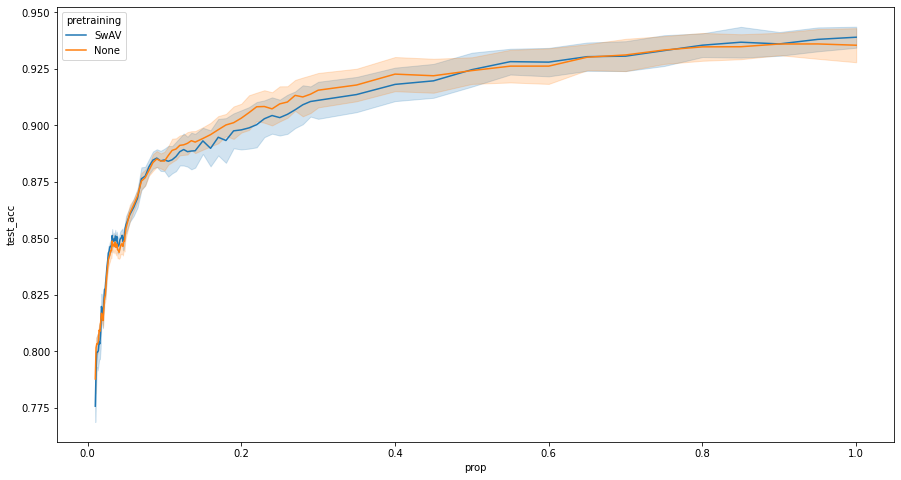

In [31]:
plt.figure(figsize=(15, 8))
sns.lineplot(
    data=df_le,
    x="prop",
    y="test_acc",
    hue="pretraining",
    ci="sd",
)

In [ ]:
props = np.around(np.sort(df_le["prop"].unique()), 3)
differences = df_le.groupby(["prop", "pretraining"], as_index=False).mean().sort_values(by=["prop", "pretraining"])["test_acc"].diff()[1::2]

In [ ]:
plt.figure(figsize=(15, 8))
plt.xticks(rotation=90, fontsize=8)
sns.barplot(x=props, y=differences)